In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
PLN_MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Aura Finance"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = None


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 415 non-null    object        
 1   author             415 non-null    object        
 2   date               415 non-null    datetime64[us]
 3   start              415 non-null    datetime64[us]
 4   end                415 non-null    datetime64[us]
 5   platform_proposal  415 non-null    object        
 6   title              415 non-null    object        
 7   description        415 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 26.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7677 entries, 0 to 7676
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        7677 non-null   object        
 1   proposal  7677 non-null   object

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0xb1f881f47bab744e7283851bc090baa626df931d,08cf9283-73d7-518a-808f-000984e42821,2022-06-17 09:57:28,1
1,0xb957dccaa1ccfb1eb78b495b499801d591d8a403,08cf9283-73d7-518a-808f-000984e42821,2022-06-17 11:49:24,1
2,0xd423b5598f2ed21a91cb79ea945c3c10836bc659,08cf9283-73d7-518a-808f-000984e42821,2022-06-17 13:33:38,1
3,0x3eedb85da27cac4ec83ab5a8a38f18b0edbc7042,08cf9283-73d7-518a-808f-000984e42821,2022-06-17 16:24:02,1
4,0x8dc4310f20d59ba458b76a62141697717f93fa41,08cf9283-73d7-518a-808f-000984e42821,2022-06-17 20:34:02,1
...,...,...,...,...
7672,0xbabb038737a7ae0dca02075e79ed5b7704c29827,416c6597-8fa2-5674-a75d-391e321554da,2023-07-16 22:22:45,1
7673,0xbabb038737a7ae0dca02075e79ed5b7704c29827,344bb922-98c2-5ef2-ab09-ed114cb7573b,2023-07-16 22:23:02,1
7674,0xbabb038737a7ae0dca02075e79ed5b7704c29827,3a773b95-59e5-55a2-bc4c-0bf8c4ff19cd,2023-07-16 22:23:22,1
7675,0xbabb038737a7ae0dca02075e79ed5b7704c29827,d2940d14-4d66-5150-acdf-037894d5f6a0,2023-07-16 22:23:43,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2023-05-12 00:00:00'),
 Timestamp('2023-05-19 00:00:00'),
 Timestamp('2023-05-26 00:00:00'),
 Timestamp('2023-06-02 00:00:00'),
 Timestamp('2023-06-09 00:00:00'),
 Timestamp('2023-06-16 00:00:00'),
 Timestamp('2023-06-23 00:00:00'),
 Timestamp('2023-06-30 00:00:00'),
 Timestamp('2023-07-07 00:00:00'),
 Timestamp('2023-07-14 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', PLN_MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in PLN_MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': PLN_MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/Aura Finance/hparams-pln-similarity_7d_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2023-05-12,all-mpnet-base-v2,7d,0.080139,0.001259,6,0.500000,0.555556,0.566667,0.433333,...,1.000000,1.0,1.0,0.150000,0.454167,0.629167,0.816667,0.816667,0.816667,0.126796
1,2023-05-12,all-mpnet-base-v2,14d,0.082324,0.001125,7,0.428571,0.428571,0.514286,0.385714,...,1.000000,1.0,1.0,0.150000,0.404167,0.629167,0.816667,0.816667,0.816667,0.124936
2,2023-05-12,all-mpnet-base-v2,21d,0.244935,0.001133,8,0.375000,0.416667,0.475000,0.350000,...,1.000000,1.0,1.0,0.150000,0.404167,0.629167,0.816667,0.816667,0.816667,0.124416
3,2023-05-12,all-mpnet-base-v2,30d,0.249733,0.001165,10,0.700000,0.533333,0.500000,0.390000,...,1.000000,1.0,1.0,0.415476,0.540625,0.684375,0.825000,0.825000,0.825000,0.125473
4,2023-05-12,all-mpnet-base-v2,60d,0.100636,0.001246,14,0.428571,0.404762,0.414286,0.307143,...,1.000000,1.0,1.0,0.318056,0.475000,0.639286,0.800000,0.800000,0.800000,0.125160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023-07-14,all-MiniLM-L6-v2,21d,0.070807,0.001112,7,0.571429,0.523810,0.571429,0.600000,...,0.494414,1.0,1.0,0.073397,0.199359,0.271047,0.522650,0.687179,0.687179,0.126252
276,2023-07-14,all-MiniLM-L6-v2,30d,0.234371,0.001120,7,0.571429,0.523810,0.571429,0.600000,...,0.494414,1.0,1.0,0.073397,0.199359,0.271047,0.522650,0.687179,0.687179,0.126721
277,2023-07-14,all-MiniLM-L6-v2,60d,0.075245,0.001161,9,0.444444,0.407407,0.444444,0.477778,...,0.421581,1.0,1.0,0.073397,0.199359,0.271047,0.522650,0.687179,0.687179,0.127229
278,2023-07-14,all-MiniLM-L6-v2,90d,0.240923,0.001170,9,0.444444,0.407407,0.466667,0.488889,...,0.532692,1.0,1.0,0.073397,0.199359,0.291880,0.543483,0.708013,0.708013,0.127395


<Axes: xlabel='window_size', ylabel='map@10'>

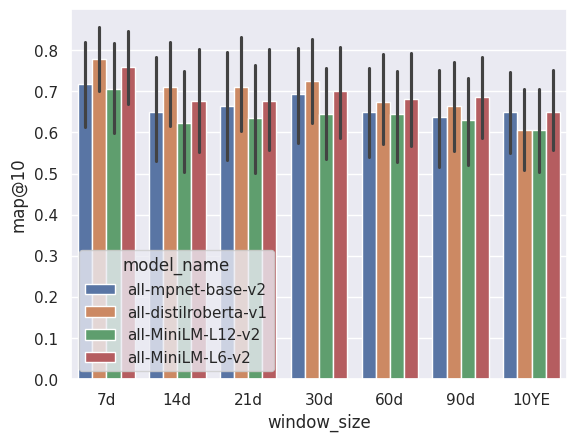

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
7d          all-distilroberta-v1    0.173350     0.678042      0.551402   
            all-MiniLM-L6-v2        0.122742     0.659153      0.542143   
21d         all-distilroberta-v1    0.175899     0.602476      0.474643   
7d          all-mpnet-base-v2       0.173160     0.629788      0.545847   
14d         all-distilroberta-v1    0.174632     0.590476      0.474321   
30d         all-distilroberta-v1    0.158686     0.595895      0.478153   
7d          all-MiniLM-L12-v2       0.178939     0.637354      0.550476   
30d         all-MiniLM-L6-v2        0.199031     0.582017      0.474978   
21d         all-MiniLM-L6-v2        0.124518     0.581462      0.466319   
14d         all-MiniLM-L6-v2        0.181378     0.575450      0.465309   
60d         all-distilroberta-v1    0.204134     0.568579      0.454166   
30d         all-mpnet-base-v2       0.195517     0.574529      0.480269   
90d         all-MiniLM-L6-v2        0.216902     0.555938      0.440203   
60d         all-MiniLM-L6-v2        0.115363     0.559959      0.441521   
21d         all-mpnet-base-v2       0.175482     0.558207      0.470763   
90d         all-distilroberta-v1    0.197095     0.556827      0.443166   
30d         all-MiniLM-L12-v2       0.143557     0.582088      0.473832   
60d         all-MiniLM-L12-v2       0.171994     0.541486      0.443285   
            all-mpnet-base-v2       0.185924     0.526165      0.446688   
14d         all-mpnet-base-v2       0.155556     0.551499      0.464444   
21d         all-MiniLM-L12-v2       0.162574     0.552342      0.468259   
10YE        all-MiniLM-L6-v2        0.533306     0.519700      0.421796   
90d         all-MiniLM-L12-v2       0.180699     0.531987      0.437117   
14d         all-MiniLM-L12-v2       0.123883     0.554780      0.469630   
10YE        all-mpnet-base-v2       0.590703     0.514683      0.424944   
90d         all-mpnet-base-v2       0.178025     0.529399      0.435882   
10YE        all-distilroberta-v1    0.574962     0.513017      0.429287   
            all-MiniLM-L12-v2       0.553834     0.509052      0.419877   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
7d          all-distilroberta-v1       0.062640  0.326089  0.355766  0.363108   
            all-MiniLM-L6-v2           0.062640  0.320128  0.350938  0.360627   
21d         all-distilroberta-v1       0.054187  0.470903  0.509983  0.530108   
7d          all-mpnet-base-v2          0.062640  0.296327  0.340106  0.348993   
14d         all-distilroberta-v1       0.053864  0.421746  0.463483  0.483718   
30d         all-distilroberta-v1       0.054967  0.515886  0.566994  0.590578   
7d          all-MiniLM-L12-v2          0.062640  0.299286  0.337401  0.344777   
30d         all-MiniLM-L6-v2           0.054967  0.501355  0.553283  0.579117   
21d         all-MiniLM-L6-v2           0.054187  0.453125  0.494232  0.519425   
14d         all-MiniLM-L6-v2           0.053864  0.407104  0.449950  0.474501   
60d         all-distilroberta-v1       0.050836  0.618993  0.678589  0.700279   
30d         all-mpnet-base-v2          0.054967  0.482072  0.552037  0.572621   
90d         all-MiniLM-L6-v2           0.049502  0.646727  0.706209  0.729926   
60d         all-MiniLM-L6-v2           0.050836  0.615557  0.667100  0.699042   
21d         all-mpnet-base-v2          0.054187  0.424931  0.489806  0.510073   
90d         all-distilroberta-v1       0.049502  0.628055  0.699036  0.722951   
30d         all-MiniLM-L12-v2          0.054967  0.479355  0.537175  0.562116   
60d         all-MiniLM-L12-v2          0.050836  0.586203  0.662071  0.688077   
            all-mpnet-base-v2          0.050836  0.568137  0.660041  0.684472   
14d         all-mpnet-base-v2          0.053864  0.376433  0.436489  0.460075   
2

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aura Finance/models/plnsim-best-avg_7d_normalize.parquet


/tmp/ipykernel_481757/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2023-05-12,7d,all-distilroberta-v1,0.244935,0.001116,6,0.500000,0.555556,0.600000,0.433333,0.288889,0.043333,0.176471,...,1.000000,1.0,1.0,0.150000,0.454167,0.679167,0.866667,0.866667,0.866667,0.123603
2023-05-19,7d,all-distilroberta-v1,0.080742,0.001265,5,0.800000,0.666667,0.600000,0.540000,0.426667,0.064000,0.333333,...,0.863095,1.0,1.0,0.369048,0.435714,0.569048,0.730952,0.764286,0.764286,0.123917
2023-05-26,7d,all-distilroberta-v1,0.079933,0.001251,4,0.500000,0.416667,0.500000,0.500000,0.333333,0.050000,0.153846,...,1.000000,1.0,1.0,0.216667,0.266667,0.388889,0.555556,0.555556,0.555556,0.124327
2023-06-02,7d,all-distilroberta-v1,0.247069,0.001237,7,0.857143,0.571429,0.600000,0.485714,0.323810,0.048571,0.428571,...,1.000000,1.0,1.0,0.308532,0.453373,0.653770,0.795635,0.795635,0.795635,0.127990
2023-06-09,7d,all-distilroberta-v1,0.246916,0.001161,4,0.500000,0.583333,0.550000,0.350000,0.233333,0.035000,0.166667,...,1.000000,1.0,1.0,0.166667,0.500000,0.833333,1.000000,1.000000,1.000000,0.123476
2023-06-16,7d,all-distilroberta-v1,0.080319,0.001110,3,0.666667,0.444444,0.466667,0.533333,0.488889,0.073333,0.181818,...,0.809524,1.0,1.0,0.535714,0.607143,0.500000,0.714286,0.809524,0.809524,0.123469
2023-06-23,7d,all-distilroberta-v1,0.080601,0.001130,7,0.714286,0.809524,0.771429,0.742857,0.495238,0.074286,0.454545,...,1.000000,1.0,1.0,0.135000,0.393056,0.500000,0.750000,0.750000,0.750000,0.124989
2023-06-30,7d,all-distilroberta-v1,0.246138,0.001225,7,1.000000,0.952381,0.914286,0.585714,0.390476,0.058571,0.636364,...,1.000000,1.0,1.0,0.186395,0.511565,0.760544,0.923810,0.923810,0.923810,0.124981
2023-07-07,7d,all-distilroberta-v1,0.247541,0.001074,3,1.000000,1.000000,0.800000,0.400000,0.266667,0.040000,0.176471,...,1.000000,1.0,1.0,0.250000,0.750000,1.000000,1.000000,1.000000,1.000000,0.121661


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aura Finance/models/plnsim-best-val_7d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-12,all-mpnet-base-v2,10YE,0.488339,0.364706,0.270588,0.027059,0.776706,0.850911,0.850911,0.740719,0.790462,0.790462,0.753431,1.000000,1.0,0.857051,0.943590,0.943590
2023-05-19,all-distilroberta-v1,7d,0.080742,0.600000,0.540000,0.064000,0.328506,0.355656,0.376517,0.703667,0.759385,0.810900,0.569048,0.863095,1.0,0.569048,0.730952,0.764286
2023-05-26,all-distilroberta-v1,14d,0.248254,0.400000,0.414286,0.041429,0.288506,0.391088,0.391088,0.451429,0.597048,0.597048,0.509524,1.000000,1.0,0.483333,0.594444,0.594444
2023-06-02,all-distilroberta-v1,7d,0.247069,0.600000,0.485714,0.048571,0.365245,0.429468,0.429468,0.662381,0.770918,0.770918,0.596088,1.000000,1.0,0.653770,0.795635,0.795635
2023-06-09,all-mpnet-base-v2,30d,0.250056,0.622222,0.355556,0.035556,0.665405,0.675473,0.675473,0.843704,0.862222,0.862222,0.922222,1.000000,1.0,0.900000,0.971429,0.971429
2023-06-16,all-distilroberta-v1,7d,0.080319,0.466667,0.533333,0.073333,0.193746,0.223822,0.236971,0.680000,0.760091,0.807710,0.500000,0.809524,1.0,0.500000,0.714286,0.809524
2023-06-23,all-distilroberta-v1,90d,0.105090,0.800000,0.718182,0.071818,0.897232,0.956698,0.956698,0.843409,0.900168,0.900168,0.611364,1.000000,1.0,0.611364,0.850000,0.850000
2023-06-30,all-distilroberta-v1,30d,0.083335,0.914286,0.585714,0.058571,0.623085,0.634068,0.634068,0.965714,0.989524,0.989524,0.808163,1.000000,1.0,0.808163,0.971429,0.971429
2023-07-07,all-MiniLM-L6-v2,21d,0.068088,0.666667,0.333333,0.033333,0.352941,0.352941,0.352941,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,0.189114,0.633455,0.508671,0.057367,0.485685,0.522929,0.528802,0.775186,0.825106,0.842158,0.665926,0.938736,1.0,0.677215,0.825526,0.852646
std,0.132982,0.193121,0.178958,0.027357,0.235851,0.242814,0.237711,0.162082,0.119880,0.116874,0.197447,0.104808,0.0,0.203229,0.142727,0.124051
min,0.068088,0.364706,0.270588,0.027059,0.193746,0.223822,0.236971,0.451429,0.597048,0.597048,0.389423,0.714744,1.0,0.389423,0.594444,0.594444
25%,0.081391,0.500000,0.370238,0.037024,0.334615,0.356533,0.378360,0.685917,0.762798,0.794774,0.524405,0.897321,1.0,0.517262,0.718452,0.799107
50%,0.172469,0.611111,0.509524,0.053571,0.365363,0.410278,0.410278,0.792064,0.805850,0.836561,0.603726,1.000000,1.0,0.632567,0.822817,0.838061
75%,0.247958,0.766667,0.574286,0.069864,0.654825,0.665121,0.665121,0.856551,0.890681,0.898283,0.794480,1.000000,1.0,0.844829,0.964469,0.964469
max,0.488339,0.914286,0.850000,0.120000,0.897232,0.956698,0.956698,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aura Finance/models/plnsim-best-test_7d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-19,all-mpnet-base-v2,10YE,0.660301,0.366667,0.416667,0.050833,0.413215,0.562210,0.634476,0.306806,0.415896,0.479217,0.377513,0.809392,1.0,0.361451,0.637812,0.661621
2023-05-26,all-distilroberta-v1,7d,0.079933,0.500000,0.500000,0.050000,0.165670,0.217655,0.217655,0.461667,0.578108,0.578108,0.458333,1.000000,1.0,0.388889,0.555556,0.555556
2023-06-02,all-distilroberta-v1,14d,0.080378,0.555556,0.422222,0.042222,0.456232,0.515205,0.515205,0.599259,0.692813,0.692813,0.722884,1.000000,1.0,0.607993,0.750000,0.750000
2023-06-09,all-distilroberta-v1,7d,0.246916,0.550000,0.350000,0.035000,0.219244,0.248928,0.248928,0.625000,0.666667,0.666667,0.666667,1.000000,1.0,0.833333,1.000000,1.000000
2023-06-16,all-mpnet-base-v2,30d,0.247748,0.366667,0.383333,0.053333,0.193746,0.274135,0.324850,0.309444,0.376257,0.441913,0.202381,0.690476,1.0,0.404762,0.571429,0.666667
2023-06-23,all-distilroberta-v1,7d,0.080601,0.771429,0.742857,0.074286,0.501793,0.567312,0.567312,0.732262,0.827027,0.827027,0.535714,1.000000,1.0,0.500000,0.750000,0.750000
2023-06-30,all-distilroberta-v1,90d,0.106138,0.844444,0.544444,0.054444,0.748319,0.759302,0.759302,0.875185,0.893704,0.893704,0.819048,1.000000,1.0,0.754762,0.933333,0.933333
2023-07-07,all-distilroberta-v1,30d,0.084049,0.577778,0.288889,0.028889,0.485992,0.485992,0.485992,0.888889,0.888889,0.888889,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
2023-07-14,all-MiniLM-L6-v2,21d,0.070807,0.571429,0.600000,0.100000,0.390236,0.421108,0.529973,0.504762,0.531859,0.643455,0.232326,0.494414,1.0,0.271047,0.522650,0.687179


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000
mean,0.184097,0.567108,0.472046,0.054334,0.397161,0.450205,0.475966,0.589253,0.652358,0.679088,0.557207,0.888254,1.0,0.569137,0.746753,0.778262
std,0.192357,0.159718,0.140354,0.021458,0.184583,0.178096,0.180074,0.216464,0.193237,0.165821,0.268801,0.185529,0.0,0.246903,0.191209,0.161219
min,0.070807,0.366667,0.288889,0.028889,0.165670,0.217655,0.217655,0.306806,0.376257,0.441913,0.202381,0.494414,1.0,0.271047,0.522650,0.555556
25%,0.080378,0.500000,0.383333,0.042222,0.219244,0.274135,0.324850,0.461667,0.531859,0.578108,0.377513,0.809392,1.0,0.388889,0.571429,0.666667
50%,0.084049,0.555556,0.422222,0.050833,0.413215,0.485992,0.515205,0.599259,0.666667,0.666667,0.535714,1.000000,1.0,0.500000,0.750000,0.750000
75%,0.246916,0.577778,0.544444,0.054444,0.485992,0.562210,0.567312,0.732262,0.827027,0.827027,0.722884,1.000000,1.0,0.754762,0.933333,0.933333
max,0.660301,0.844444,0.742857,0.100000,0.748319,0.759302,0.759302,0.888889,0.893704,0.893704,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
